In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import os
os.chdir('C:/Users/clack/Projects/nwm')

from experiment.nav2d import Topo

from experiment.cdit import load_cdit
from experiment.vae import decode_latents, encode_image, make_vae
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = 'cuda'

vae = make_vae().to(device)
vae.load_state_dict(torch.load('checkpoints/vae/topo/check1249.pt'))
cdit = load_cdit('D:/nwm-out/nwm-cdit-s-topo2/checkpoints/1103.pth.tar')

print('Demonstrating next frame prediction by trained CDiT')
state = Topo.random()
image = state.render(128)
latent = cdit([encode_image(vae, image)], [np.array([5, 0])])
next_predicted_image = decode_latents(vae, latent.to(device))[0]

fig, axes = plt.subplots(1, 2)
axes[0].imshow(image)
axes[1].imshow(next_predicted_image)

<All keys matched successfully>

In [ ]:
import cv2
import numpy as np
from experiment.nav2d import Topo

print('Realtime next frame prediction comparison to actual state')
state = Topo.random()
CAMERA_RESOLUTION = 128
UPSCALE_RESOLUTION = 512

def upscale(image: np.ndarray):
  return cv2.resize(
    cv2.cvtColor(
      image,
      cv2.COLOR_RGB2BGR
    ),
    (UPSCALE_RESOLUTION, UPSCALE_RESOLUTION),
    interpolation=cv2.INTER_NEAREST
  )

click_data = None

def on_click(event, x, y, flags, param):
    global click_data
    if event != cv2.EVENT_LBUTTONDOWN:
        return
    click_position = np.array([x, y], dtype=np.float32) / UPSCALE_RESOLUTION
    displacement = (click_position - 0.5) * CAMERA_RESOLUTION
    click_data = displacement  # Just store the data

initial_image = state.render(CAMERA_RESOLUTION).astype(np.float32)
latent = [encode_image(vae, initial_image)]

side_by_side = np.concatenate((upscale(initial_image), upscale(initial_image)), axis=1)
cv2.imshow('worldstate', side_by_side)
cv2.setMouseCallback('worldstate', on_click)

# main loop that handles GPU operations
while True:
    key = cv2.waitKey(10)  # small delay
    
    if click_data is not None:
        displacement = click_data
        click_data = None  # reset flag
        
        state.act(displacement)
        real_image = state.render(CAMERA_RESOLUTION).astype(np.float32)
        
        latent = cdit(latent, [displacement])
        predicted_image = decode_latents(vae, latent)[0]
        
        side_by_side = np.concatenate((upscale(real_image), upscale(predicted_image)), axis=1)
        cv2.imshow('worldstate', side_by_side)
    
    if key == 27:  # ESC to exit
        break

cv2.destroyAllWindows()

In [ ]:
import cv2
from IPython.display import Video
from tqdm import tqdm

class WindingWalkPolicy:
  def __init__(self, step_size: float = 2, max_wind_per_step: float = 1.0) -> None:
    self.step_size = step_size
    self.max_angular_deviation = max_wind_per_step
    self.angle = np.random.rand() * 2 * np.pi

  def __call__(self, _) -> np.ndarray:
    self.angle += 2 * (np.random.rand() - 0.5) * self.max_angular_deviation
    return self.step_size * np.array([np.cos(self.angle), np.sin(self.angle)])

print('Saving world model rollout to video')
out_path = 'out.mp4'
state = Topo.random()
policy = WindingWalkPolicy()

actual_images = [state.render(128).astype(np.float32)]
predicted_images = [actual_images[0]]
latent = encode_image(vae, actual_images[0])
for frame in tqdm(range(20), desc='CDiT forward passes'):
  action = policy(state)
  state.act(action)
  latent = cdit([latent], [action.astype(np.float32)])[0]
  actual_images.append(state.render(128).astype(np.float32))
  predicted_images.append(decode_latents(vae, latent.unsqueeze(0))[0])

render_images =  [
  np.concatenate((upscale(actual), upscale(predicted)), axis=1)
  for actual, predicted in zip(actual_images, predicted_images)
]
out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'mp4v'), 1, (render_images[0].shape[1], render_images[0].shape[0]))
for image in render_images:
  out.write((image * 255).astype(np.uint8))
out.release()

Video(out_path)

CDiT forward passes:   0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([4, 16, 16]) (2,)


CDiT forward passes:   5%|▌         | 1/20 [00:02<00:53,  2.82s/it]

torch.Size([4, 16, 16]) (2,)


CDiT forward passes:  10%|█         | 2/20 [00:05<00:49,  2.73s/it]

torch.Size([4, 16, 16]) (2,)


CDiT forward passes:  15%|█▌        | 3/20 [00:08<00:47,  2.80s/it]

torch.Size([4, 16, 16]) (2,)


CDiT forward passes:  20%|██        | 4/20 [00:11<00:44,  2.77s/it]

torch.Size([4, 16, 16]) (2,)


CDiT forward passes:  25%|██▌       | 5/20 [00:13<00:41,  2.74s/it]

torch.Size([4, 16, 16]) (2,)


CDiT forward passes:  30%|███       | 6/20 [00:16<00:38,  2.73s/it]

torch.Size([4, 16, 16]) (2,)


CDiT forward passes:  35%|███▌      | 7/20 [00:19<00:35,  2.72s/it]

torch.Size([4, 16, 16]) (2,)


CDiT forward passes:  40%|████      | 8/20 [00:21<00:32,  2.71s/it]

torch.Size([4, 16, 16]) (2,)


CDiT forward passes:  45%|████▌     | 9/20 [00:24<00:29,  2.72s/it]

torch.Size([4, 16, 16]) (2,)


CDiT forward passes:  50%|█████     | 10/20 [00:27<00:27,  2.72s/it]

torch.Size([4, 16, 16]) (2,)


CDiT forward passes:  55%|█████▌    | 11/20 [00:30<00:24,  2.71s/it]

torch.Size([4, 16, 16]) (2,)


CDiT forward passes:  60%|██████    | 12/20 [00:32<00:21,  2.70s/it]

torch.Size([4, 16, 16]) (2,)


CDiT forward passes:  65%|██████▌   | 13/20 [00:35<00:18,  2.69s/it]

torch.Size([4, 16, 16]) (2,)


CDiT forward passes:  70%|███████   | 14/20 [00:38<00:16,  2.69s/it]

torch.Size([4, 16, 16]) (2,)


CDiT forward passes:  75%|███████▌  | 15/20 [00:40<00:13,  2.70s/it]

torch.Size([4, 16, 16]) (2,)


CDiT forward passes:  80%|████████  | 16/20 [00:43<00:10,  2.69s/it]

torch.Size([4, 16, 16]) (2,)


CDiT forward passes:  85%|████████▌ | 17/20 [00:46<00:08,  2.68s/it]

torch.Size([4, 16, 16]) (2,)


CDiT forward passes:  90%|█████████ | 18/20 [00:48<00:05,  2.68s/it]

torch.Size([4, 16, 16]) (2,)


CDiT forward passes:  95%|█████████▌| 19/20 [00:51<00:02,  2.68s/it]

torch.Size([4, 16, 16]) (2,)


CDiT forward passes: 100%|██████████| 20/20 [00:54<00:00,  2.71s/it]


In [1]:
import os
os.chdir('C:/Users/clack/Projects/nwm')
import heapq
import numpy as np
from experiment.nav2d import Topo

def distance_map(
  state: Topo, start: np.ndarray, max_distance: float, forbidden_margin: int = 0
) -> np.ndarray:
  start_block = start.round().astype(np.uint32)
  
  distance = np.full((state.terrain_size, state.terrain_size), np.inf, dtype=np.float32)
  distance[start_block[1], start_block[0]] = 0

  edges = np.array(
    [np.array([0, 1]), np.array([1, 0]), np.array([0, -1]), np.array([-1, 0])]
    + [np.array([1, 1]), np.array([1, -1]), np.array([-1, 1]), np.array([-1, -1])]
  )
  edge_lengths = np.array([1] * 4 + [2**0.5] * 4)

  visited = np.zeros((state.terrain_size, state.terrain_size), dtype=bool)
  heads = [(0.0, tuple(start_block))]
  
  while heads:
    distance_from_start, head_tuple = heapq.heappop(heads)
    head = np.array(head_tuple, dtype=np.uint32)
    
    if visited[head[1], head[0]]:
      continue
    visited[head[1], head[0]] = True

    neighbors = head[None, :] + edges
    out_of_bounds = (neighbors < forbidden_margin).any(-1) | (neighbors >= state.terrain_size - forbidden_margin).any(-1)
    neighbors = neighbors[~out_of_bounds]

    estimated_neighbor_distances = distance_from_start + edge_lengths[~out_of_bounds]
    dead_end = (
      (state.terrain[neighbors[:, 1], neighbors[:, 0]] >= state.wall_height)
      | (estimated_neighbor_distances >= distance[neighbors[:, 1], neighbors[:, 0]])
      | (estimated_neighbor_distances > max_distance)
    )
    neighbors = neighbors[~dead_end]
    estimated_neighbor_distances = estimated_neighbor_distances[~dead_end]
    
    distance[neighbors[:, 1], neighbors[:, 0]] = estimated_neighbor_distances
    for neighbor, dist in zip(neighbors, estimated_neighbor_distances):
      heapq.heappush(heads, (dist, tuple(neighbor)))

  return distance

In [18]:
from typing import Callable, Generic, List, Sequence, Tuple, TypeVar

S = TypeVar('S')
A = TypeVar('A')
class PlanningGraph(Generic[S, A]):
  def __init__(
    self,
    world_model: Callable[[Sequence[S], Sequence[A]], Sequence[S]],
    distance_function: Callable[[Sequence[S], Sequence[S]], Sequence[float]],
    sample_actions: Callable[[Sequence[S]], Sequence[Sequence[A]]]
  ) -> None:
    self.world_model = world_model
    self.distance_function = distance_function
    self.sample_actions = sample_actions

    self.priorities: List[float] = []
    self.nodes: List[S] = []
    self.explored_edges: List[List[Tuple[int, A]]] = []
    self.unexplored_edges: List[List[A]] = []
    self.distances_to_goal: List[float] = []

    # 1. choose node with closest distance to goal
    # 2. choose node least saturated with actions

    # we could score actions based on:
    # 1. how close the root node is to the goal
    # X 2. how close neighbors to the root node are to the goal X (distance function should encapsulate)
    # 2. how unexplored the actions of a node are

  def plan_trajectory(self, starting_state: S, goal_state: S) -> List[A] | None:
    ambivalence = 0.0
    success_distance_threshold = 3.0

    self.distances_to_goal = [max(1, self.distance_function([starting_state], [goal_state])[0])]
    self.nodes = [starting_state]
    self.source_edges = [(-1, None)]
    self.unexplored_edges = [list(self.sample_actions([starting_state])[0])]

    if self.distances_to_goal[0] <= success_distance_threshold:
      return []

    explorations_allowed = 30
    while explorations_allowed:
      explorations_allowed -= 1
      unexplored_edges = sum([[
        (state_index, action_index) for action_index in range(len(actions))
      ] for state_index, actions in enumerate(self.unexplored_edges)], [])
      if not unexplored_edges:
        break
      relative_distances_to_goal = np.array(self.distances_to_goal) - min(self.distances_to_goal)
      # print(relative_distances_to_goal)
      if relative_distances_to_goal.max() > 0:
        relative_distances_to_goal = relative_distances_to_goal / relative_distances_to_goal.max()

        distance_scores = np.array([relative_distances_to_goal[state_index] for state_index, _ in unexplored_edges])
        distance_scores = distance_scores.max() - distance_scores
        distance_scores = distance_scores / distance_scores.sum()
      else:
        distance_scores = np.ones(len(unexplored_edges)) / len(unexplored_edges)
      # print(distance_scores)
      # print(distance_scores)
      edge_scores = distance_scores * (1 - ambivalence) + np.full_like(distance_scores, ambivalence / len(distance_scores))

      # print(edge_scores)
      state_index, action_index = unexplored_edges[
        np.random.choice(np.arange(len(unexplored_edges), dtype=np.int32), p=edge_scores)
      ]
      action = self.unexplored_edges[state_index].pop(action_index)
      # [].pop()
      state = self.nodes[state_index]
      new_state = self.world_model([state], [action])[0]
      goal_distance = self.distance_function([new_state], [goal_state])[0]

      check_proximity = np.random.choice(len(self.nodes), size=min(4, len(self.nodes)), replace=False)
      check_proximity = [self.nodes[i] for i in check_proximity]
      distances_to_others = self.distance_function([new_state] * len(check_proximity), check_proximity)
      if min(distances_to_others) > 2:
        self.unexplored_edges.append(list(self.sample_actions([new_state])[0]))

      self.nodes.append(new_state)
      self.source_edges.append((state_index, action))
      self.distances_to_goal.append(max(1, goal_distance))

      if goal_distance <= success_distance_threshold:
        trajectory = []
        current_state_index = len(self.nodes) - 1
        while current_state_index != 0:
          current_state_index, action = self.source_edges[current_state_index]
          trajectory.append(action)
        return list(reversed(trajectory))
    return None

world_model_calls = 0
distance_calls = 0
def world_model(states: Sequence[Topo], actions: Sequence[np.ndarray]) -> List[Topo]:
  global world_model_calls
  world_model_calls += 1
  next_states = []
  for state, action in zip(states, actions):
    next_state = state.copy()
    next_state.act(action)
    next_states.append(next_state)
  return next_states

def distance_function(states1: Sequence[Topo], states2: Sequence[Topo]) -> List[float]:
  global distance_calls
  distance_calls += 1
  distances = []
  for state1, state2, in zip(states1, states2):
    target_position = state2.position.round().astype(np.long)
    distance = distance_map(state1, start=state1.position, max_distance=128)[target_position[1], target_position[0]]
    distances.append(distance)
  return distances




graph = PlanningGraph(
  world_model=world_model,
  distance_function=distance_function,
  sample_actions=lambda states: (
    len(states) * [
      [4 * np.array([np.cos(angle), np.sin(angle)]) for angle in np.arange(0, 2 * np.pi, np.pi / 2)]
    ])
)




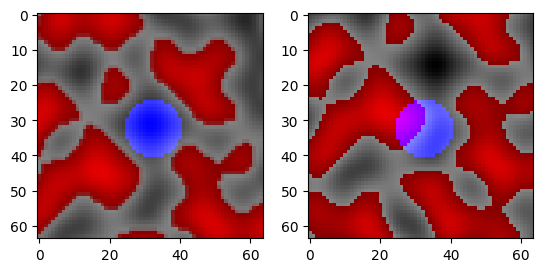

In [16]:
start_state = Topo.random()
target_position = (start_state.position + (np.random.rand(2) * 2 - 1) * 20).round().astype(np.int32)
while start_state.terrain[target_position[1], target_position[0]] >= start_state.wall_height:
  target_position = (start_state.position + (np.random.rand(2) * 2 - 1) * 20).round().astype(np.int32)

start_state_image = start_state.render(64)

goal_state = start_state.copy()
goal_state.position = target_position
goal_state_image = goal_state.render(64)

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2)
axes[0].imshow(start_state_image)
axes[1].imshow(goal_state_image)

None 30 61


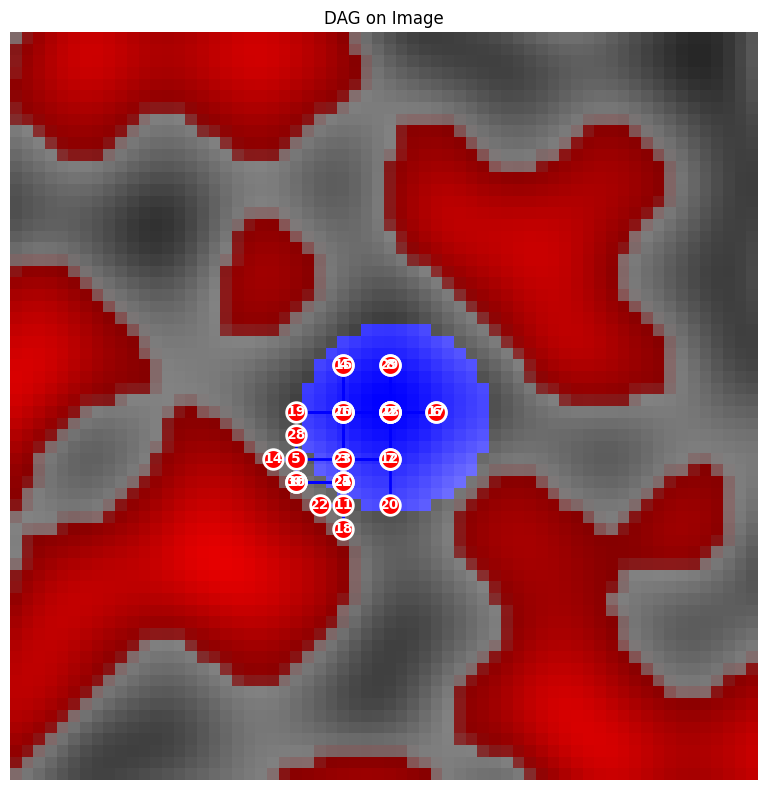

In [19]:

world_model_calls = 0
distance_calls = 0
trajectory = graph.plan_trajectory(start_state, goal_state)
print(trajectory, world_model_calls, distance_calls)
plt.figure(figsize=(10, 8))
plt.imshow(start_state_image)

nodes = [state.position - start_state.position + 32 for state in graph.nodes]
parent = [node_index for node_index, _ in graph.source_edges]

# nodes = [np.array([32, 14]), np.array([3, 7])]
# parent = [-1, 0]

# Draw edges first (so they appear behind nodes)
for i, p in enumerate(parent):
    if p != -1:  # Skip root node
        # Draw line from parent to current node
        x = [nodes[p][0], nodes[i][0]]
        y = [nodes[p][1], nodes[i][1]]
        plt.plot(x, y, 'b-', linewidth=2, zorder=1)

# Draw nodes on top
for i, node in enumerate(nodes):
    # Draw node as a circle
    plt.scatter(node[0], node[1], s=200, c='red',
                edgecolors='white', linewidths=2, zorder=2)
    # Optionally add node labels
    plt.text(node[0], node[1], str(i), fontsize=10,
             fontweight='bold', ha='center', va='center',
             color='white', zorder=3)

plt.title("DAG on Image")
plt.axis('off')  # Optional: hide axes
plt.tight_layout()
plt.show()

In [32]:
sum([0.72649574 ,0.72649574, 0.72649574, 0.72649574, 0.72649574, 0.72649574,
 0.72649574, 0.72649574 ,0.72649574 ,0.8153846  ,0.8153846 , 0.8153846,
 0.8153846 ])

9.800000059999999

In [ ]:
def world_model(states: Sequence[torch.Tensor], actions: Sequence[np.ndarray]) -> List[torch.Tensor]:
  next_states = []
  for state, action in zip(states, actions):
    next_state = state.copy()
    next_state.act(action)
    next_states.append(next_state)
  return next_states

def distance_function(states1: Sequence[torch.Tensor], states2: Sequence[torch.Tensor]) -> List[float]:
  distances = []
  for state1, state2, in zip(states1, states2):
    target_position = state2.position.round().astype(np.long)
    distance = distance_map(state1, start=state1.position, max_distance=128)[target_position[1], target_position[0]]
    distances.append(distance)
  return distances




graph = PlanningGraph(
  world_model=world_model,
  distance_function=distance_function,
  sample_actions=lambda states: (
    len(states) * [
      [4 * np.array([np.cos(angle), np.sin(angle)]) for angle in np.arange(0, 2 * np.pi, np.pi / 2)]
    ])
)